In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from tqdm import tqdm 

def load_data(tcga=True):
    if tcga: 
        file_path_data = "TCGAdata.txt"
        file_path_labels = "TCGAlabels.txt"
        delimiter=' '
    else:
        file_path_data = "CATSnDOGS.csv"
        file_path_labels = "Labels.csv"
        delimiter=',' 
    df_data = pd.read_csv(file_path_data, delimiter=delimiter, header=0, quotechar='"')
    df_labels = pd.read_csv(file_path_labels, delimiter=delimiter, header=0, quotechar='"')
    return df_data.values, df_labels.values 

def standardize(train_data, test_data):
    sc = StandardScaler()
    train_data = sc.fit_transform(train_data)
    test_data = sc.transform(test_data)
    return train_data, test_data

def feature_selection(data, labels, classifier):
    sel = VarianceThreshold(threshold=0.0)
    data_cleaned = sel.fit_transform(data)
    #X_test = sel.transform(X_test)

    feature_range = range(1, data_cleaned.shape[1] + 1, 100)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    num_features = [] 
    for n_features in feature_range:
        anova = SelectKBest(score_func=f_classif, k=n_features)
        data_feature_reduced = anova.fit_transform(data_cleaned, labels)
        cv_scores = cross_val_score(classifier, data_feature_reduced, labels, cv=kf)
        mean_cv_score = np.mean(cv_scores)
        scores.append(mean_cv_score)
        num_features.append(n_features)
    
    print(f"#features: {num_features[np.where(scores == np.max(scores))[0][0]]}, score: {np.max(scores)}") 
    return scores, num_features

(array([  1.,   5.,   7.,   7.,  14.,  21.,  28.,  59.,  69.,  78., 103.,
        132., 130., 156., 193., 198., 198., 193., 209., 197., 202., 162.,
        135., 111., 114., 140., 112., 125., 100., 112., 101.,  79.,  87.,
         68.,  68.,  64.,  62.,  52.,  58.,  32.,  34.,  27.,  24.,  18.,
          6.,   2.,   2.,   0.,   0.,   1.]),
 array([2772.77553311, 2843.10254872, 2913.42956433, 2983.75657994,
        3054.08359555, 3124.41061116, 3194.73762677, 3265.06464238,
        3335.39165799, 3405.7186736 , 3476.04568922, 3546.37270483,
        3616.69972044, 3687.02673605, 3757.35375166, 3827.68076727,
        3898.00778288, 3968.33479849, 4038.6618141 , 4108.98882971,
        4179.31584532, 4249.64286093, 4319.96987654, 4390.29689215,
        4460.62390776, 4530.95092338, 4601.27793899, 4671.6049546 ,
        4741.93197021, 4812.25898582, 4882.58600143, 4952.91301704,
        5023.24003265, 5093.56704826, 5163.89406387, 5234.22107948,
        5304.54809509, 5374.8751107 , 5445.202

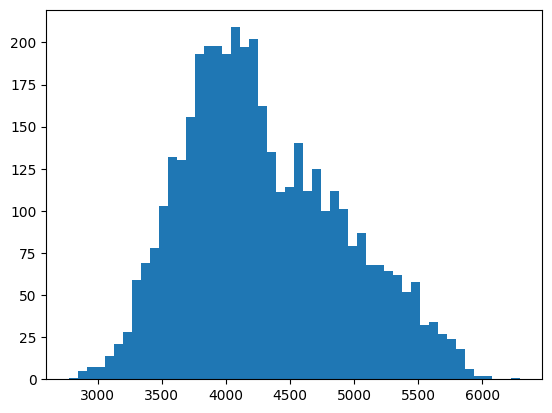

In [5]:
# Checking variance distribution 

data, labels = load_data(tcga=False)
plt.hist(np.var(data, axis=0), bins=50)


#features: 2401, score: 0.783076923076923


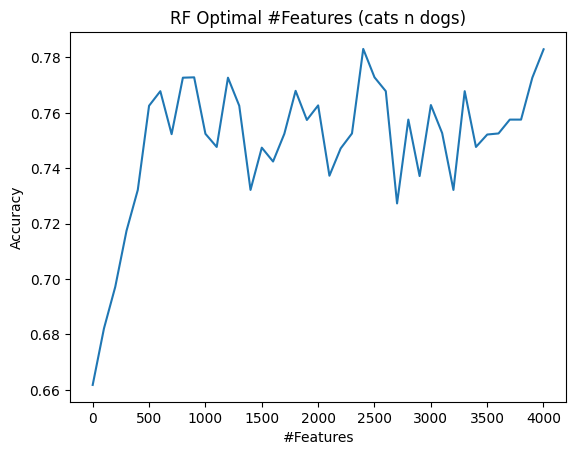

#features: 1801, score: 0.7829487179487179


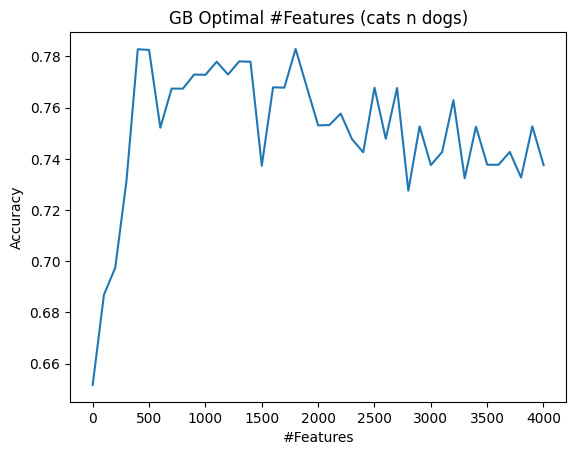

In [6]:
# searching for optimal num of features with cross val 
data, labels = load_data(tcga=False)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

classifier_rf = RandomForestClassifier(n_estimators=100) 
classifier_gb = GradientBoostingClassifier(n_estimators=100) 

scores, num_features = feature_selection(data, labels.ravel(), classifier_rf)
plt.plot(num_features, scores) 
plt.title("RF Optimal #Features (cats n dogs)")
plt.xlabel("#Features")
plt.ylabel("Accuracy")
plt.show()
scores, num_features = feature_selection(data, labels.ravel(), classifier_gb)
plt.plot(num_features, scores) 
plt.title("GB Optimal #Features (cats n dogs)")
plt.xlabel("#Features")
plt.ylabel("Accuracy")
plt.show()

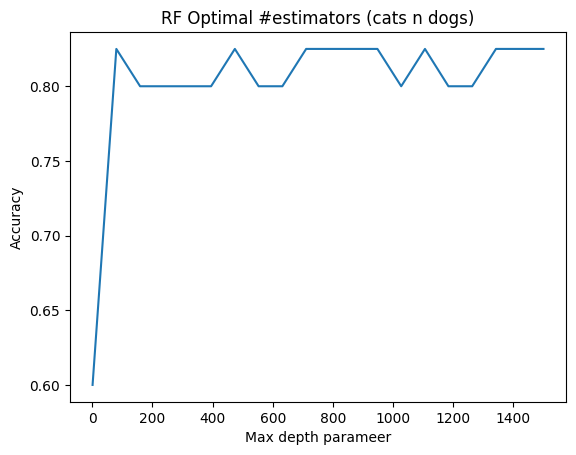

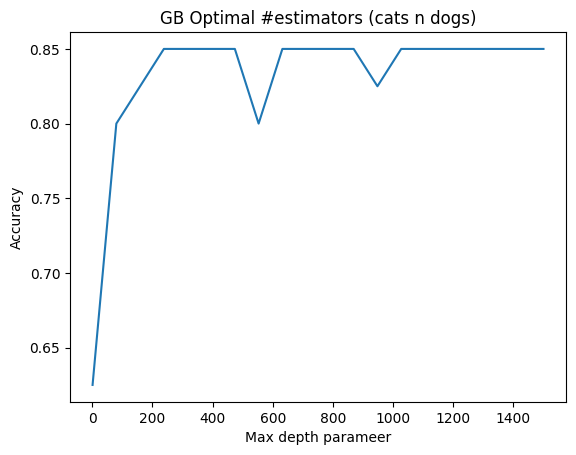

In [11]:
# searching for optimal #estimators 
data, labels = load_data(tcga=False)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

anova = SelectKBest(score_func=f_classif, k=1000)
X_train_feature = anova.fit_transform(X_train, y_train.ravel())
X_test_feature = anova.transform(X_test)
X_train_stand, X_test_stand = standardize(X_train_feature, X_test_feature)

accuracies_rf = []
accuracies_gb = []
estimator_range = np.linspace(1, 1500, 20)

for estimators in estimator_range:
    classifier_rf = RandomForestClassifier(n_estimators=int(estimators)) 
    classifier_gb = GradientBoostingClassifier(n_estimators=int(estimators)) 

    classifier_rf.fit(X_train_stand, y_train.ravel())
    y_pred_test = classifier_rf.predict(X_test_stand)
    accuracy = accuracy_score(y_test, y_pred_test)
    accuracies_rf.append(accuracy)

    classifier_gb.fit(X_train_stand, y_train.ravel())
    y_pred_test = classifier_gb.predict(X_test_stand)
    accuracy = accuracy_score(y_test, y_pred_test)
    accuracies_gb.append(accuracy)


plt.plot(np.around(estimator_range).astype(int), accuracies_rf) 
plt.title("RF Optimal #Estimators (cats n dogs)")
plt.xlabel("#Estimators")
plt.ylabel("Accuracy")
plt.show()
plt.plot(np.around(estimator_range).astype(int), accuracies_gb) 
plt.title("GB Optimal #Estimators (cats n dogs)")
plt.xlabel("#Estimators")
plt.ylabel("Accuracy")
plt.show()

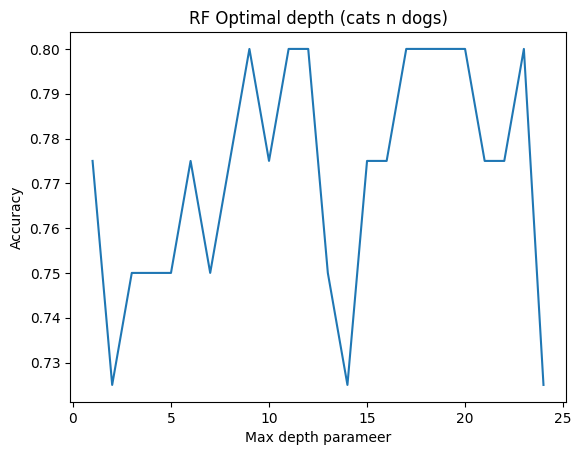

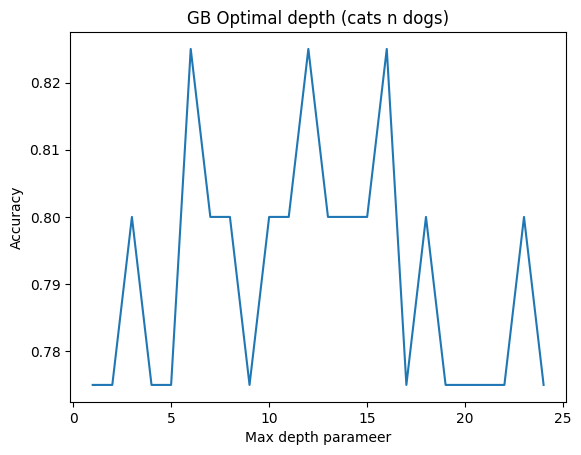

In [13]:
# searching for optimal depth 
data, labels = load_data(tcga=False)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

anova = SelectKBest(score_func=f_classif, k=1000)
X_train_feature = anova.fit_transform(X_train, y_train.ravel())
X_test_feature = anova.transform(X_test)
X_train_stand, X_test_stand = standardize(X_train_feature, X_test_feature)

accuracies_rf = []
accuracies_gb = []
depth_range = range(1,25)

for depth in depth_range:
    classifier_rf = RandomForestClassifier(n_estimators=100, max_depth=depth) 
    classifier_gb = GradientBoostingClassifier(n_estimators=100, max_depth=depth) 

    classifier_rf.fit(X_train_stand, y_train.ravel())
    y_pred_test = classifier_rf.predict(X_test_stand)
    accuracy = accuracy_score(y_test, y_pred_test)
    accuracies_rf.append(accuracy)

    classifier_gb.fit(X_train_stand, y_train.ravel())
    y_pred_test = classifier_gb.predict(X_test_stand)
    accuracy = accuracy_score(y_test, y_pred_test)
    accuracies_gb.append(accuracy)


plt.plot(depth_range, accuracies_rf) 
plt.title("RF Optimal depth (cats n dogs)")
plt.xlabel("Max depth parameer")
plt.ylabel("Accuracy")
plt.show()
plt.plot(depth_range, accuracies_gb) 
plt.title("GB Optimal depth (cats n dogs)")
plt.xlabel("Max depth parameer")
plt.ylabel("Accuracy")
plt.show()